In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn
import itertools as it

/home/anders/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )
cnts

AnnData object with n_obs × n_vars = 55656 × 23433 
    obs: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

In [21]:
cnts.X.__class__

scipy.sparse.csr.csr_matrix

In [23]:
cntsT = cnts.transpose()
cntsT

AnnData object with n_obs × n_vars = 23433 × 55656 
    var: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

In [24]:
cntsT.X.__class__

scipy.sparse.csr.csr_matrix

In [25]:
endo_gold = cnts.obs_names[ ( cntsT["Pecam1",:].X > 3 ) & ( cntsT["Cdh5",:].X > 3 ) ]
endo_gold

Index(['10X_P4_3_CCGTTCAGTTCCCTTG', '10X_P4_4_ACTGAGTGTTGCGTTA',
       '10X_P4_4_ATCTACTAGGCAATTA', '10X_P4_4_CATGACAAGGACTGGT',
       '10X_P4_4_CCTAAAGAGCTCCTTC', '10X_P4_4_CGATCGGAGTGGAGTC',
       '10X_P4_4_GAATGAAAGCTTATCG', '10X_P4_4_GCACTCTCAGCGATCC',
       '10X_P4_4_GCTTCCAAGTCCTCCT', '10X_P4_4_GTCCTCATCATGTGGT',
       ...
       '10X_P8_15_GCTGCAGCAGGGAGAG', '10X_P8_15_GGGAGATCACTTCTGC',
       '10X_P8_15_GGTGTTAAGATCCCGC', '10X_P8_15_GTAACGTGTAATAGCA',
       '10X_P8_15_TAGAGCTAGTTTAGGA', '10X_P8_15_TCAACGACATTCCTGC',
       '10X_P8_15_TCGTAGAAGCTTATCG', '10X_P8_15_TTGCCGTGTCAACTGT',
       '10X_P8_15_TTGTAGGCATCAGTCA', '10X_P8_15_TTTGTCAGTTGTCGCG'],
      dtype='object', name='index', length=915)

In [26]:
exprs = cnts.copy()
exprs.X = sp.sparse.vstack( np.sqrt( cnts.X[i,:] ) / np.sqrt( cnts.X[i,:].sum() ) for i in range(cnts.n_obs) )

In [27]:
a = exprs[ endo_gold, : ].X
endo_gold_dists = ( a * a.transpose() ).todense() 
assert endo_gold_dists.max() < 1.001
endo_gold_dists[ endo_gold_dists > 1 ] = 1
endo_gold_dists = np.arccos( endo_gold_dists ) / ( np.pi / 2 )

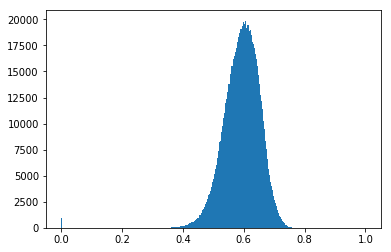

In [28]:
plt.hist( endo_gold_dists.flat, 300, range=(0,1) );

In [29]:
a = exprs[ np.random.choice( exprs.obs_names, endo_gold.shape[0] ), : ].X
dists_sample = ( a * a.transpose() ).todense() 
assert dists_sample.max() < 1.001
dists_sample[ dists_sample > 1 ] = 1
dists_sample = np.arccos( dists_sample ) / ( np.pi/2 )

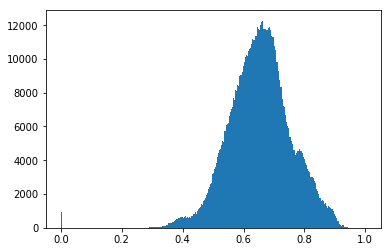

In [30]:
plt.hist( dists_sample.flat, 300, range=(0,1) );

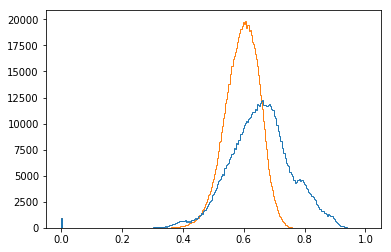

In [31]:
plt.hist( [ np.asarray(dists_sample).flatten(), np.asarray(endo_gold_dists).flatten() ], 
         bins=300, range=(0,1), histtype="step" );

In [41]:
a = ( exprs.X * exprs.X[17864,:].transpose() ).todense()
a[ a>1 ] = 1
a = np.arccos( a ) / ( np.pi / 2 )

In [44]:
( a < .45 ).sum()

46

In [15]:
( cnts.X.data,
  cnts.X.indices,
  cnts.X.indptr )

(array([ 1.,  1.,  1., ..., 15.,  1.,  1.], dtype=float32),
 array([    3,    10,    22, ..., 23281, 23304, 23336], dtype=int32),
 array([        0,      2853,      7047, ..., 106601619, 106602592,
        106604392], dtype=int32))

In [117]:
a = exprs.X[ 0:20, ]

In [119]:
# Scalar product:

d = np.zeros( (20,20), np.float32)
for cellA in range(20):
    for cellB in range(20):
        indptrA = a.indptr[cellA]
        indptrB = a.indptr[cellB]
        s = 0
        while indptrA < a.indptr[cellA+1] and indptrB < a.indptr[cellB+1]:
            if a.indices[indptrA] < a.indices[indptrB]:
                indptrA += 1
            elif a.indices[indptrA] > a.indices[indptrB]:
                indptrB += 1
            else:  # a.indices[indptrA] == a.indices[indptrB]
                s += a.data[indptrA] * a.data[indptrB]
                indptrA += 1
                indptrB += 1
        d[ cellA, cellB ] = s
        
np.subtract( d, ( a * a.transpose() ).todense() )


matrix([[-2.46661283e-08, -2.86321522e-09, -2.84519396e-08,
         -2.79180212e-08,  2.84867230e-08,  2.95551912e-08,
         -1.36655576e-08,  1.81990976e-08,  1.19329537e-08,
         -4.47524884e-09, -8.65007133e-09,  8.32356162e-09,
         -1.89631200e-09, -1.41924038e-08,  9.04271824e-09,
          2.03542582e-08, -1.59164090e-08,  7.53620699e-09,
         -3.03442427e-09, -1.29230319e-08],
        [-2.86321522e-09, -1.30739606e-08,  1.98530957e-08,
         -3.94489807e-09,  2.20583528e-08,  1.04078008e-08,
          1.41292472e-08, -1.95584681e-08, -1.06612330e-08,
          3.06812320e-09,  2.77784540e-08, -2.78153398e-08,
          6.25099150e-09, -1.09072440e-08, -2.40741742e-08,
         -2.81843812e-08, -1.15863762e-08, -1.67214897e-09,
          8.61683391e-09,  2.78568588e-08],
        [-2.84519396e-08,  1.98530957e-08, -5.59799032e-08,
         -6.01102679e-09,  2.41861111e-08,  2.65089946e-08,
          2.58485719e-08,  2.47926769e-08,  9.91871874e-09,
          2.

In [156]:
# Scalar product, calculated via Euclidean distance
# Set to zero all scalar products smaller than 0.4

def square(x):
    return x * x

d = np.zeros( (20,20), np.float32)
for cellA in range(20):
    for cellB in range(20):
        indptrA = a.indptr[cellA]
        indptrB = a.indptr[cellB]
        s = 0
        while indptrA < a.indptr[cellA+1] and indptrB < a.indptr[cellB+1]:
            if a.indices[indptrA] < a.indices[indptrB]:
                s += square( a.data[indptrA] )
                indptrA += 1
            elif a.indices[indptrA] > a.indices[indptrB]:
                s += square( a.data[indptrB] )
                indptrB += 1
            else:  # a.indices[indptrA] == a.indices[indptrB]
                s += square( a.data[indptrA] - a.data[indptrB] )
                indptrA += 1
                indptrB += 1
            if s > 0.4:
                break
        else:
            d[ cellA, cellB ] = 1 - s/2 
        
print( d[1:5,1:5] )

ss = ( a * a.transpose() ).todense()
print( ss[1:5,1:5] )

[[1.         0.80533105 0.         0.        ]
 [0.80533105 1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
[[0.99999989 0.80530248 0.69370592 0.7994915 ]
 [0.80530248 1.00000006 0.69331492 0.79616973]
 [0.69370592 0.69331492 0.9999999  0.67353   ]
 [0.7994915  0.79616973 0.67353    1.00000005]]


In [143]:
# Next step: Change the else clause of the while loop such that it adds an entry to a sparse matrix 
# and that we build up a sparse 

matrix([[0.63461083]])

In [144]:
np.arccos( 1 - d[1,2]/2 )

0.634562640395829